# Setup

In [3]:
import argparse
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from tqdm.auto import tqdm
import matplotlib
import traceback
import sys

from utils import *
from compare_uid import *
matplotlib.use('nbAgg')

c:\Users\tianq\Desktop\LIGN 169\Balancing-The-Flow\Scripts\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tianq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
%matplotlib inline

# Data Prep

In [11]:
UID_metrics = load_metrics_files(Path("../UID_Analysis").iterdir())

Loaded metrics from human_texts/cnn_dailymail: 300 texts
Loaded metrics from human_texts/daily_dialog: 300 texts
Loaded metrics from human_texts/old_analysis: 300 texts
Loaded metrics from human_texts/writingprompts: 300 texts
Total files loaded: 4
Loaded metrics from llama-2-7b-32k-instruct@q8_0/cnn_dailymail: 300 texts
Loaded metrics from llama-2-7b-32k-instruct@q8_0/daily_dialog: 298 texts
Loaded metrics from llama-2-7b-32k-instruct@q8_0/old_analysis: 300 texts
Loaded metrics from llama-2-7b-32k-instruct@q8_0/WildChat: 160 texts
Loaded metrics from llama-2-7b-32k-instruct@q8_0/writingprompts: 300 texts
Total files loaded: 9
Loaded metrics from llama-2-7b-chat@q8_0/cnn_dailymail: 300 texts
Loaded metrics from llama-2-7b-chat@q8_0/daily_dialog: 150 texts
Loaded metrics from llama-2-7b-chat@q8_0/old_analysis: 300 texts
Loaded metrics from llama-2-7b-chat@q8_0/writingprompts: 300 texts
Total files loaded: 13
Loaded metrics from llama-2-7b@q8_0/cnn_dailymail: 300 texts
Loaded metrics fro

In [12]:
UID_metrics.shape

(9500, 10)

In [13]:
human = ['human_texts']
base_lm = [
    'llama-2-7b@q8_0', 
    'mistral-7b-v0.1@q8_0',
    ]
instruct = [
    'llama-2-7b-32k-instruct@q8_0',
    # 'mistral-7b-instruct-v0.3', 
    'mistral-instruct-01@q8_0',
    ]
chat = ['llama-2-7b-chat@q8_0', 
        'mistral-plus-7b@q8_0']

UID_metrics['model_class'] = UID_metrics['model'].apply(lambda model: 'human' if model in human 
                                                      else 'base' if model in base_lm
                                                      else 'instruct' if model in instruct 
                                                      else 'chat' if model in chat
                                                      else 'other')
UID_metrics = UID_metrics[UID_metrics['model_class'] != 'other']

In [14]:
UID_metrics['model_class'].value_counts()

model_class
base        4092
chat        1950
instruct    1358
human       1200
Name: count, dtype: int64

In [15]:
# subsampling based on model and model class
subsamp_model = (UID_metrics.groupby('model')
                .apply(lambda df: df.sample(UID_metrics['model'].value_counts().min(), replace=False, random_state=42))
                .reset_index(drop=True))
subsamp_model_class = (UID_metrics.groupby('model_class')
                    .apply(lambda df: df.sample(UID_metrics['model_class'].value_counts().min(), replace=False, random_state=42))
                    .reset_index(drop=True))
subsamp_model_class['model_class'].value_counts()

C:\Users\tianq\AppData\Local\Temp\ipykernel_27168\3256901191.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(UID_metrics['model'].value_counts().min(), replace=False, random_state=42))
C:\Users\tianq\AppData\Local\Temp\ipykernel_27168\3256901191.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(UID_metrics['model_class'].value_counts().min(), rep

model_class
base        1200
chat        1200
human       1200
instruct    1200
Name: count, dtype: int64

In [16]:
UID_metrics.set_index('filename')['uid_pairwise'].idxmax()

'mistral-7b-v0.1_162.csv'

# Model UID Analysis

In [17]:
UID_metrics.head()

,filename,tokens,mean_surprisal,median_surprisal,min_surprisal,max_surprisal,uid_variance,uid_pairwise,model,dataset,model_class
0,human_0.csv,1023,4.604102,3.649326,0.000349,22.953438,15.685920,33.299091,human_texts,cnn_dailymail,human
1,human_1.csv,555,5.177666,4.305730,0.001140,33.627064,17.811668,35.412906,human_texts,cnn_dailymail,human
2,human_10.csv,800,4.414787,3.422870,0.000193,23.141106,14.973570,30.192351,human_texts,cnn_dailymail,human
3,human_100.csv,1023,4.386267,3.285722,0.000359,26.830626,18.072004,33.192981,human_texts,cnn_dailymail,human
4,human_101.csv,1023,4.594937,3.579399,0.000011,18.135799,16.566306,30.772802,human_texts,cnn_dailymail,human


In [18]:
UID_metrics.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])

C:\Users\tianq\AppData\Local\Temp\ipykernel_27168\3489711922.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  UID_metrics.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])


tokens  mean_surprisal  median_surprisal  min_surprisal  \
model_class                                                                     
base        mean  320.445748        4.272573          3.256471       0.066417   
            std   342.160768        1.253909          1.573618       0.353628   
chat        mean  243.616410        3.970239          3.074042       0.011138   
            std   177.348264        0.701072          0.727540       0.081058   
human       mean  529.657500        4.970888          3.881324       0.028710   
            std   346.233088        0.742112          0.786892       0.146025   
instruct    mean  672.453608        3.447548          2.432584       0.024200   
            std   418.638540        1.223987          1.479315       0.203518   

                  max_surprisal  uid_variance  uid_pairwise  
model_class                                                  
base        mean      20.996266     17.322969     32.433800  
            std        9.156274     22.566016     43.923314  
chat        mean      19.401695     13.040559     25.227046  
            std        4.809366      4.271205      8.238020  
human       mean      22.643851     18.389676     35.592437  
            std        3.625535      4.352748      8.380943  
instruct    mean      21.152224     12.386359     22.499223  
            std        7.551340      5.087288     11.740948

In [19]:
UID_metrics.groupby(["dataset", "model"]).apply(lambda df: df.describe().loc[['mean']])

C:\Users\tianq\AppData\Local\Temp\ipykernel_27168\1935143797.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  UID_metrics.groupby(["dataset", "model"]).apply(lambda df: df.describe().loc[['mean']])


tokens  mean_surprisal  \
dataset        model                                                            
WildChat       llama-2-7b-32k-instruct@q8_0 mean   661.412500        3.491190   
               llama-2-7b@q8_0              mean   644.438356        3.718253   
cnn_dailymail  human_texts                  mean   742.756667        4.344916   
               llama-2-7b-32k-instruct@q8_0 mean  1001.020000        2.903192   
               llama-2-7b-chat@q8_0         mean   323.036667        3.573186   
               llama-2-7b@q8_0              mean   421.273333        4.216886   
               mistral-7b-v0.1@q8_0         mean   426.936667        3.984512   
               mistral-plus-7b@q8_0         mean   258.573333        4.196171   
daily_dialog   human_texts                  mean   122.053333        5.360219   
               llama-2-7b-32k-instruct@q8_0 mean   367.110738        3.695590   
               llama-2-7b-chat@q8_0         mean   172.506667        4.500768   
               llama-2-7b@q8_0              mean   509.503378        3.876895   
               mistral-7b-v0.1@q8_0         mean   469.513333        3.980618   
old_analysis   human_texts                  mean   626.910000        5.089209   
               llama-2-7b-32k-instruct@q8_0 mean   398.276667        3.993493   
               llama-2-7b-chat@q8_0         mean   114.860000        3.889432   
               llama-2-7b@q8_0              mean   128.369000        4.623964   
               mistral-7b-v0.1@q8_0         mean   316.710000        3.709316   
               mistral-plus-7b@q8_0         mean   143.963333        3.789976   
writingprompts human_texts                  mean   626.910000        5.089209   
               llama-2-7b-32k-instruct@q8_0 mean   927.260000        3.176296   
               llama-2-7b-chat@q8_0         mean   317.080000        4.011128   
               llama-2-7b@q8_0              mean   662.703333        4.053173   
               mistral-7b-v0.1@q8_0         mean   636.370000        3.862523   
               mistral-plus-7b@q8_0         mean   339.740000        4.096276   

                                                  median_surprisal  \
dataset        model                                                 
WildChat       llama-2-7b-32k-instruct@q8_0 mean          2.257136   
               llama-2-7b@q8_0              mean          2.633096   
cnn_dailymail  human_texts                  mean          3.270224   
               llama-2-7b-32k-instruct@q8_0 mean          1.833160   
               llama-2-7b-chat@q8_0         mean          2.602029   
               llama-2-7b@q8_0              mean          3.358580   
               mistral-7b-v0.1@q8_0         mean          3.170185   
               mistral-plus-7b@q8_0         mean          3.333039   
daily_dialog   human_texts                  mean          4.155957   
               llama-2-7b-32k-instruct@q8_0 mean          2.755964   
               llama-2-7b-chat@q8_0         mean          3.501818   
               llama-2-7b@q8_0              mean          3.260744   
               mistral-7b-v0.1@q8_0         mean          2.664483   
old_analysis   human_texts                  mean          4.049557   
               llama-2-7b-32k-instruct@q8_0 mean          3.064566   
               llama-2-7b-chat@q8_0         mean          2.931760   
               llama-2-7b@q8_0              mean          3.460470   
               mistral-7b-v0.1@q8_0         mean          2.427571   
               mistral-plus-7b@q8_0         mean          2.871546   
writingprompts human_texts                  mean          4.049557   
               llama-2-7b-32k-instruct@q8_0 mean          2.172375   
               llama-2-7b-chat@q8_0         mean          3.115482   
               llama-2-7b@q8_0              mean          3.405287   
               mistral-7b-v0.1@q8_0         mean          3.155887   
               mistral-plus-7b@q8_0         mea

In [20]:
UID_metrics['model'].value_counts()

model
llama-2-7b@q8_0                 3042
llama-2-7b-32k-instruct@q8_0    1358
human_texts                     1200
llama-2-7b-chat@q8_0            1050
mistral-7b-v0.1@q8_0            1050
mistral-plus-7b@q8_0             900
Name: count, dtype: int64

In [21]:
main_cmap = {
    'human': 'green',
    'base': 'steelblue',
    'instruct': 'firebrick',
    'chat': 'orange',
}
main_cmap.update({
    'human_texts': main_cmap['human'],
    ####
    'llama-2-7b': main_cmap['base'],
    'mistral-7b-v0.1': main_cmap['base'],
    ####
    'llama-2-7b-32k-instruct': main_cmap['instruct'],
    'mistral-instruct-01': main_cmap['instruct'],
    ####
    'llama-2-7b-chat': main_cmap['chat'],
    'mistral-plus-7b': main_cmap['chat']
})

Text(0.5, 1.0, 'Mean vs. median surprisal values')

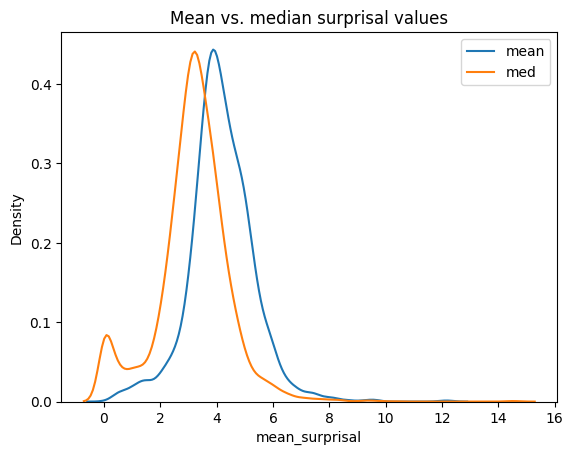

In [22]:
sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', label='mean')
sns.kdeplot(data=subsamp_model_class, x='median_surprisal', label='med')
plt.legend()
plt.title("Mean vs. median surprisal values")

(0.0, 1024.0)

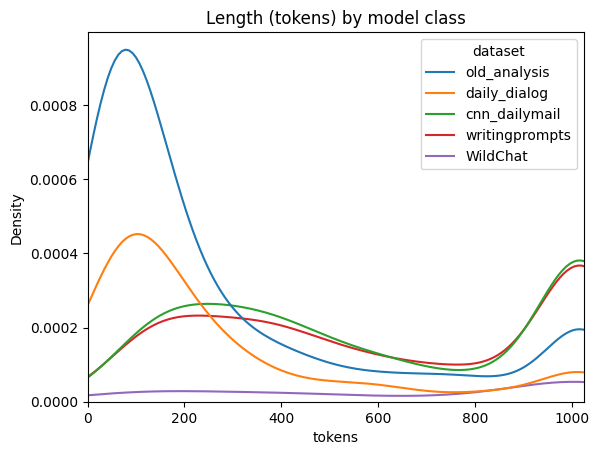

In [25]:
# sns.kdeplot(data=subsamp_model_class, x='tokens', hue='model_class', palette=main_cmap)
sns.kdeplot(data=subsamp_model_class, x='tokens', hue='dataset')
plt.title("Length (tokens) by model class")
plt.xlim(0, 1024)

<Axes: xlabel='mean_surprisal', ylabel='Density'>

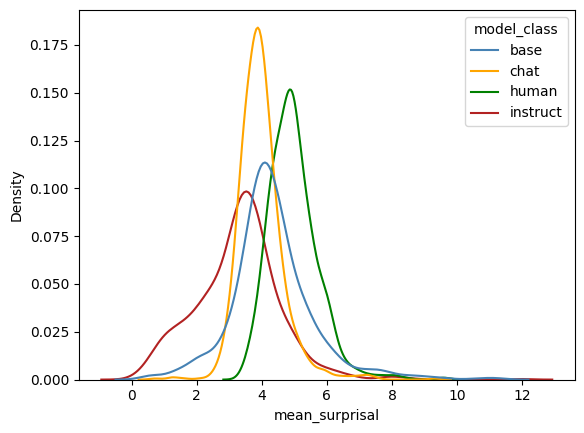

In [33]:

sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', hue='model_class', palette=main_cmap)

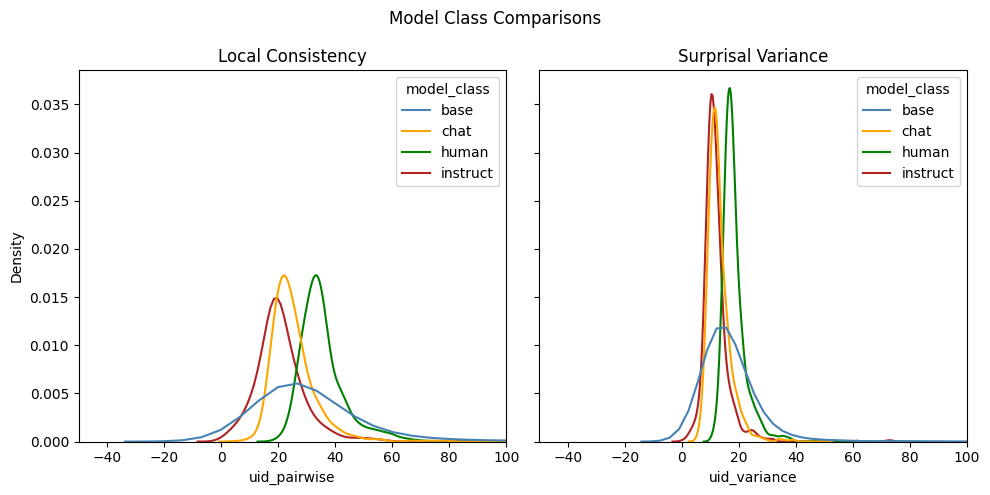

In [34]:
def plot_uid_measures(df, hue='model', titles=("Local consistency", "Surprisal variance"), suptitle="", cmap=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    sns.kdeplot(data=df, x='uid_pairwise', hue=hue, ax=axs[0], palette=cmap)
    axs[0].set_xlim(-50, 100)
    axs[0].set_title(titles[0].title())

    sns.kdeplot(data=df, x='uid_variance', hue=hue, ax=axs[1], palette=cmap)
    axs[1].set_title(titles[1].title())

    plt.suptitle(suptitle.title())
    plt.tight_layout()
plot_uid_measures(subsamp_model_class, hue='model_class', suptitle='Model Class Comparisons', cmap=main_cmap)

In [25]:
UID_metrics['model'].value_counts()

model
llama-2-7b@q8_0                 2757
human_texts                     1200
llama-2-7b-32k-instruct@q8_0    1050
llama-2-7b-chat@q8_0            1050
mistral-7b-v0.1@q8_0            1050
mistral-plus-7b@q8_0             900
Name: count, dtype: int64

In [19]:
llama_models = ['llama-2-7b', 'llama-2-7b-32k-instruct', 'llama-2-7b-chat']
mistral_models = ['mistral-7b-v0.1', 'mistral-instruct-01', 'mistral-plus-7b']

llama_metrics = subsamp_model[subsamp_model['model'].isin(llama_models + ['human_texts'])]
mistral_metrics = subsamp_model[subsamp_model['model'].isin(mistral_models + ['human_texts'])]

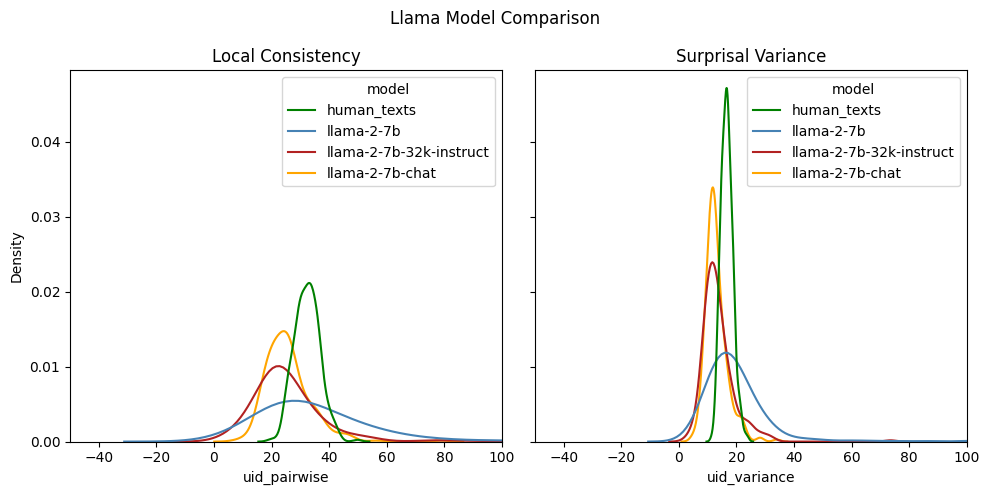

In [106]:
plot_uid_measures(llama_metrics, hue='model', suptitle="Llama model comparison", cmap=main_cmap)

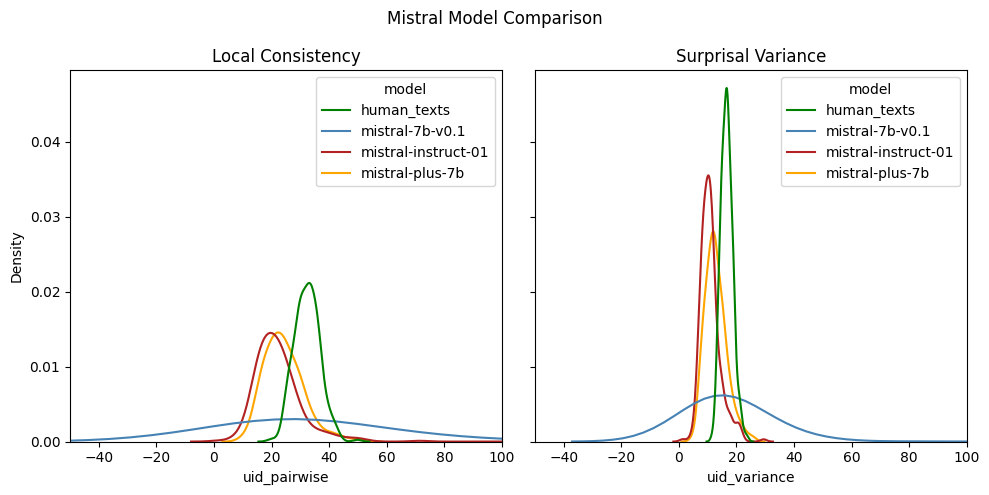

In [107]:
plot_uid_measures(mistral_metrics, hue='model', suptitle="mistral model comparison", cmap=main_cmap)

# Domain Analysis

In [39]:
metrics = subsamp_model_class

humans_only = metrics[metrics['model'] == "human_texts"]

C:\Users\tianq\AppData\Local\Temp\ipykernel_19624\4249752321.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_uid_measures(humans_only[subsamp_model_class['dataset'] != "old_analysis"], hue='dataset', suptitle='Model Class Comparisons')


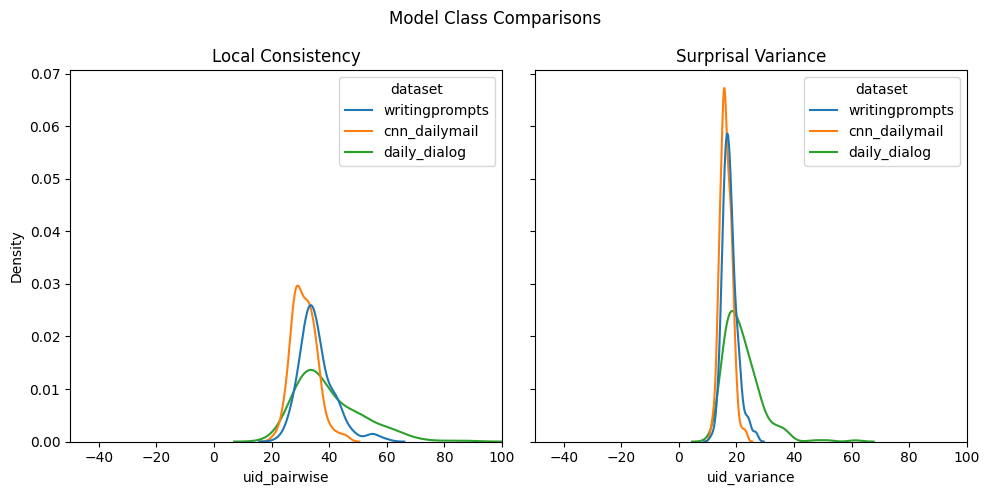

In [40]:
plot_uid_measures(humans_only[subsamp_model_class['dataset'] != "old_analysis"], hue='dataset', suptitle='Model Class Comparisons')

# Statistical Testing

## KS-Test

In [108]:
from scipy.stats import ks_2samp

In [109]:
# comparing models to human
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.2955), pvalue=np.float64(2.1438462913993263e-77), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.553), pvalue=np.float64(9.620252363063907e-75), statistic_location=np.float64(14.062003121620585), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.6178333333333333), pvalue=np.float64(4.382201874450111e-95), statistic_location=np.float64(14.054966771711786), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.399), pvalue=np.float64(8.270760859355696e-38), statistic_location=np.float64(13.209420799630436), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.7936666666666666), pvalue=np.f

In [110]:
metric = 'uid_variance'
n_unique_models = UID_metrics['model_class'].nunique()
all_model_classes = UID_metrics['model_class'].unique()
model_class_results = dict()
for model_class in all_model_classes:
    d1 = UID_metrics.loc[UID_metrics['model_class'] == model_class, metric]
    d2 = UID_metrics.loc[UID_metrics['model_class'] == 'human', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_class_results[model_class] = result
model_class_results

{'human': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'base': KstestResult(statistic=np.float64(0.283), pvalue=np.float64(5.858867162014141e-76), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'instruct': KstestResult(statistic=np.float64(0.6591666666666667), pvalue=np.float64(4.021011440751329e-192), statistic_location=np.float64(13.01102194310928), statistic_sign=np.int8(1)),
 'chat': KstestResult(statistic=np.float64(0.5993333333333334), pvalue=np.float64(7.13602454719481e-156), statistic_location=np.float64(13.756461577948546), statistic_sign=np.int8(1))}

Text(0.5, 1.0, 'Ks Test Statistics For Different Models, Comparing To Human')

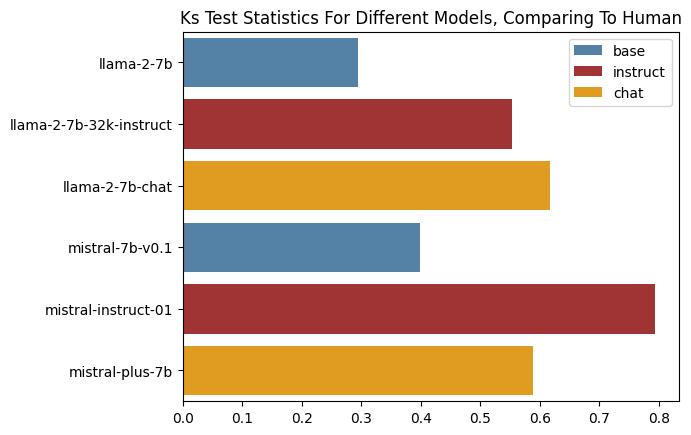

In [111]:
sns.barplot(y=list(model_results.keys())[1:], x=[result.statistic for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("KS Test Statistics for different models, comparing to human".title())

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

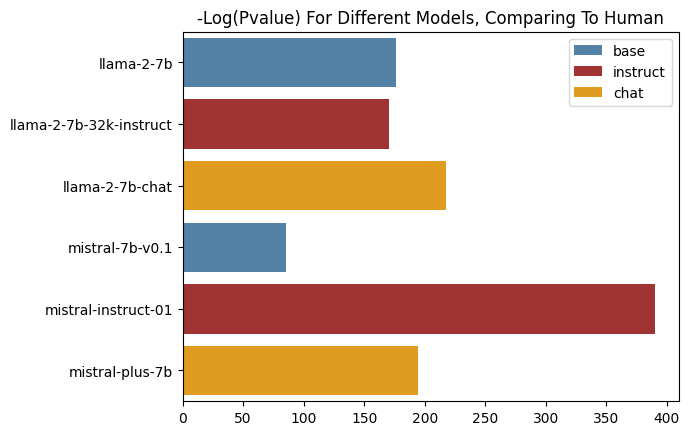

In [114]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

In [116]:
# testing effect of centering distributions
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d1 -= d1.mean()
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d2 -= d2.mean()
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(-5.2065832385089585), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.468), pvalue=np.float64(2.9993355631007798e-198), statistic_location=np.float64(-3.0605661327315588), statistic_sign=np.int8(1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.2771666666666667), pvalue=np.float64(3.595838020006057e-18), statistic_location=np.float64(-2.4557801822844993), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.14916666666666667), pvalue=np.float64(1.579350526583561e-05), statistic_location=np.float64(-1.8911929886334118), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.61), pvalue=np.float64(1.872192688082596e-92), statistic_location=np.float64(-3.1635327125480224), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.1318333333333

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

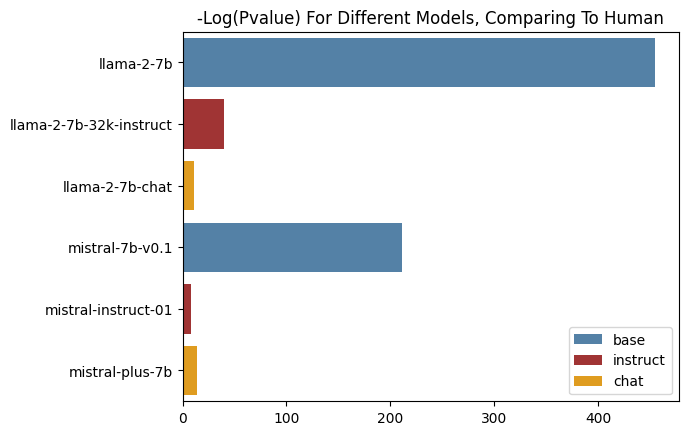

In [117]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

## KL Divergence

In [119]:
from scipy.stats import entropy

In [ ]:
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d1 = d1.sample(min(len(d1), len(d2)))
    result = entropy(pk=d1, qk=d2)
    model_results[model] = result
model_results

ValueError: Array shapes are incompatible for broadcasting.

# Classification

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
import xgboost as xgb

## Predicting Model from UID

In [15]:
subsamp_model['model'] = pd.factorize(subsamp_model['model'], sort=True)[0]
subsamp_model['model_class'] = pd.factorize(subsamp_model['model_class'], sort=True)[0]
subsamp_model['model'].value_counts()

model
0    300
1    300
2    300
3    300
4    300
5    300
6    300
Name: count, dtype: int64

In [16]:
X = subsamp_model[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.7755208333333333, 0.6875)

In [ ]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.6520833333333333

In [ ]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.6791666666666667

## Predicting Model Class from UID

In [17]:
subsamp_model_class = (UID_metrics.groupby('model_class')
              .apply(lambda df: df.sample(300, replace=False, random_state=42))
              .reset_index(drop=True))
subsamp_model_class['model'] = pd.factorize(subsamp_model_class['model'], sort=True)[0]
subsamp_model_class['model_class'] = pd.factorize(subsamp_model_class['model_class'], sort=True)[0]
subsamp_model_class['model_class'].value_counts()

C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_35780\2176402028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(300, replace=False, random_state=42))


model_class
0    300
1    300
2    300
3    300
Name: count, dtype: int64

In [18]:
X = subsamp_model_class[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model_class['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [19]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.8697916666666666, 0.725)

In [20]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.675

In [21]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.7375